# Convolutional Neural Net From Scratch

For UCLA Math 156: Machine Learning with Prof. Lara Kassab, Spring 2024 \
Created by Sia Phulambrikar, Anya Smolentseva, and Nathan Wetmore

Note: to run this code please dowload the Tom and Jerry dataset from Kaggle [here](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification).\
You will need to drag all images from the four seperate class folders into a single new folder titled `frames`. The `frames` folder and the `ground_truths.csv` must be located in the same directory as this notebook.

### Importing required libraries

In [11]:
#imports required for code
import pandas as pd
import cv2 #run pip install opencv-python
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from PIL import Image
import re

### Image Preprocessing

In [12]:
#set the image size we want to use
desired_width = 224
desired_height = 224

# Read ground truth CSV
labels_path = '/Users/sia/Library/CloudStorage/OneDrive-UCLAITServices/math 156/project/data/ground_truth.csv'
img_path = '/Users/sia/Library/CloudStorage/OneDrive-UCLAITServices/math 156/project/data/images/'

ground_truth = pd.read_csv(labels_path)

temp = [img for img in os.listdir(img_path) if img.endswith(".jpg")]
def extract_number(temp):
    match = re.search(r'\d+', temp)
    return int(match.group()) if match else 0

sorted_filenames = sorted(temp, key=extract_number)

# Function to load and preprocess a single image
def load_and_preprocess_image(filename):
    img = cv2.imread(os.path.join(img_path, filename))
    if img is not None:
        if len(img.shape) == 2 or img.shape[2] == 1:
            gray_img = img
        else:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = cv2.resize(gray_img, (desired_width, desired_height))
        gray_img = (gray_img / 255.0) - 0.5
        return gray_img
    else:
        return None


images = []

for filename in tqdm(sorted_filenames):
    img = load_and_preprocess_image(filename)
    if img is not None:
        images.append(img)

# Convert images to a NumPy array
images = np.array(images)

# Check shapes to confirm everything is correct
print(images.shape)

100%|██████████████████████████████████████| 5478/5478 [00:09<00:00, 569.89it/s]


(5478, 224, 224)


### Preprocessing Target Values

In [13]:
#read in classifications
y_true = pd.read_csv(labels_path)

def class_creator(row):
    '''
    returns a class 0-3 for the 4 image classes
    -row: dataframe row to be worked with
    '''
    #only tom is in the frame = class 0
    if (row['tom'] == 1) & (row['jerry'] == 0):
        val = 0
    #only jerry is in the frame = class 1
    elif (row['tom'] == 0) & (row['jerry'] == 1):
        val = 1
    #neither tom nor jerry is in the frame = class 2
    elif (row['tom'] == 0) & (row['jerry'] == 0):
        val = 2
    #both tom and jerry are in the frame = class 3
    else:
        val = 3
    return val

ground_truth['class'] = ground_truth.apply(class_creator, axis=1)
y_true = ground_truth['class'].values

y_true.shape

(5478,)

Due to limitations with computational power, we decided to train our model on 1000 rows of data, with a train-test-val split of 60-20-20.

In [14]:
#random subsampling of data
random_permutation = np.random.permutation(images.shape[0])

X = images[random_permutation]
y = y_true[random_permutation]

X = images[0:834]
y = y_true[0:834]

#splitting into train, test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state = 50)

X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state = 50)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape) 
print("Test set:", X_test.shape, y_test.shape)

Training set: (500, 224, 224) (500,)
Validation set: (167, 224, 224) (167,)
Test set: (167, 224, 224) (167,)


## Model Creation

### Convolution Layer

In [30]:
class Conv2D:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9 
        
    def iterate_regions(self,image):
        '''
        iterates over 2*2 regions of an image to apply Conv Layer
        '''
        h, w = image.shape
        for i in range(h-2):
            for j in range (w-2):
                region = image[i:(i+3), j:(j+3)]
                yield region, i, j
                
    def forward(self, input_val):
        '''
        computes forward pass for the Convolutional layer
        '''
        self.last_input = input_val
        h, w = input_val.shape
        output = np.zeros ((h-2,w-2,self.num_filters))
        for region, i, j in self.iterate_regions(input_val):
            output[i,j] = np.sum(region * self.filters, axis=(1,2))
        
        return output
    
    def backprop(self, dL_dout, learn_rate):
        '''
        Performs a backward pass of the Convolutional layer
        '''
        dL_dfilters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                dL_dfilters[f] += dL_dout[i, j, f] * im_region

        # update filters based on loss gradient with respect to filters
        self.filters -= learn_rate * dL_dfilters

        return None


### Pooling Layer

In [31]:
class MaxPooling2D:
    def iterate_regions(self, image):
        '''
        iterates over 2*2 regions of an image to apply MaxPool Layer
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield region, i, j
            
    def forward(self, input_val):
        '''
        computes forward pass for the MaxPool layer
        '''
        self.last_input = input_val

        h, w, num_filters = input_val.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input_val):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output
    
    def backprop(self, dL_dout):
        '''
        computes backprop pass for the MaxPool layer
        '''
        dL_dinput = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            dL_dinput[i * 2 + i2, j * 2 + j2, f2] = dL_dout[i, j, f2]

        return dL_dinput

### Dense Softmax Layer

In [32]:
class Softmax:
  #Final layer with Softmax activation

    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
        computes forward pass for the Softmax layer
        '''
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, dL_dout, learn_rate):
        '''
        computes backward pass for the Softmax layer
        '''
        for i, gradient in enumerate(dL_dout):
            if gradient == 0:
                continue

        t_exp = np.exp(self.last_totals)
        S = np.sum(t_exp)

        dout_dt = -t_exp[i] * t_exp / (S ** 2)
        dout_dt[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

        dt_dw = self.last_input
        dt_db = 1
        dt_dinputs = self.weights

        # Gradients of loss against totals
        dL_dt = gradient * dout_dt

        # Gradients of loss against weights/biases/input
        dL_dw = dt_dw[np.newaxis].T @ dL_dt[np.newaxis]
        dL_db = dL_dt * dt_db
        dL_dinputs = dt_dinputs @ dL_dt

        # Update weights / biases
        self.weights -= learn_rate * dL_dw
        self.biases -= learn_rate * dL_db

        return dL_dinputs.reshape(self.last_input_shape)

### The Model Class

In [33]:
class CNN: 
    #CNN model class with functions to train model, generate model plots and predictions
    def __init__(self,num_filters,img_size,num_classes):
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.test = 2
        self.conv = Conv2D(self.num_filters)                  
        self.pool = MaxPooling2D()                  
        self.softmax = Softmax(111 * 111 * self.num_filters, 
                               self.num_classes)
    
    def forward(self, image, label):
        '''
        computes forward pass for the CNN, with 1 Conv Layer, 1 Pooling Layer and a Final Softmax layer
        '''
        out = self.conv.forward(image)
        out = self.pool.forward(out)
        out = self.softmax.forward(out)

        #calculate cross entropy loss and accuracy
        loss = -np.log(out[label])
        acc = 1 if np.argmax(out) == label else 0

        return out, loss, acc

    def train_im(self, im, label, lr=.005):
        '''
        computes backward pass and trains model on a single image
        '''
        #forward pass
        out, loss, acc = self.forward(im, label)

        #calculating gradient
        gradient = np.zeros(4)
        gradient[label] = -1 / out[label]

        #performing backprop
        gradient = self.softmax.backprop(gradient, lr)
        gradient = self.pool.backprop(gradient)
        gradient = self.conv.backprop(gradient, lr)

        return loss, acc
    
    def train_model(self, X_train, y_train, X_val, y_val, epochs, lr = 0.005):
        '''
        - trains model on a complete dataset X_train
        - evaluates model on validation set X_val
        '''
        self.epochs = epochs
        val_loss_history = []
        train_loss_history = []
        
        for epoch in range(epochs):
            print('--- Epoch %d ---' % (epoch + 1))

            permutation = np.random.permutation(len(X_train))
            X_train = X_train[permutation]
            y_train = y_train[permutation]
            
            # Train!
            loss = 0
            n_correct = 0

            #record avg loss and accuracy every 100 steps
            epoch_loss_history = []
            epoch_acc_history = []
            
            for i, (im, label) in enumerate(zip(X_train, y_train)):
              if i % 100 == 99: 
                  avg_loss = loss/100
                  print(
                      '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                      (i + 1, avg_loss, n_correct)
                  )
                  
                  epoch_loss_history.append(avg_loss) 
                  epoch_acc_history.append(n_correct)
                  loss = 0
                  n_correct = 0
        
              l, acc = mymodel.train_im(im, label)
              loss += l
              n_correct += acc

            train_loss_history.append(np.nanmean(epoch_loss_history))

            #Evaluating on validation set
            val_loss = 0
            val_correct = 0
            for i, (im, label) in enumerate(zip(X_val, y_val)):
                _, l, acc = self.forward(im, label)
                val_loss += l
                val_correct += acc
                
            val_loss = val_loss/len(y_val)
            val_acc = val_correct/len(y_val)
            val_loss_history.append(val_loss)

            print('[Epoch %d]: Training Loss %.3f | Training Accuracy %d%%' %
                  (epoch + 1, np.nanmean(epoch_loss_history), np.nanmean(epoch_acc_history)))

            print('[Epoch %d]: Validation Loss %.3f | Validation Accuracy %d%%' %
                  (epoch + 1, val_loss, val_acc*100))
            

        self.train_loss_history = train_loss_history
        self.val_loss_history = val_loss_history

        return None
        
            

    def plot_model(self):
        '''
        - Plots average training loss history over Epochs
        - Plots average validation loss history over Epochs
        '''
        fig, axs = plt.subplots(2, constrained_layout = True)
        #plotting training loss
        axs[0].plot(range(1, self.epochs + 1), self.train_loss_history)
        axs[0].set_title('Training Loss over Time')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Average Loss')
        

        #plotting validation loss
        axs[1].plot(range(1, self.epochs + 1), self.val_loss_history)
        axs[1].set_title('Validation Loss over Time')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Average Loss')
        
        fig.tight_layout()
        plt.show()
        
        print(self.val_loss_history)
        return None
            
            
    def predict(self, X, y):
        '''
        Computes forward pass of trained model to generate:
        - y_pred: array of predicted class labels
        - test_loss: average loss on test set
        - test accuracy: accuracy on test set
        '''
        y_pred = []
        
        for i, (im, label) in enumerate(zip(X, y)):
            out, l, acc = self.forward(im, label)
            pred = np.argmax(out)
            y_pred.append(pred)
            test_loss += l
            n_correct += acc
        test_loss = test_loss/len(y)
        test_acc = n_correct/len(y)
        
        return y_pred, test_loss, test_acc

## Running the Model

In [34]:
mymodel = CNN(8, X_train[0].shape,4)

In [35]:
mymodel.train_model(X_train,y_train,X_val,y_val,5)

--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 3.825 | Accuracy: 16%
[Step 200] Past 100 steps: Average Loss 4.816 | Accuracy: 21%
[Step 300] Past 100 steps: Average Loss 5.155 | Accuracy: 22%
[Step 400] Past 100 steps: Average Loss 5.150 | Accuracy: 14%
[Step 500] Past 100 steps: Average Loss 5.858 | Accuracy: 26%
[Epoch 1]: Training Loss 4.961 | Training Accuracy 19%
[Epoch 1]: Validation Loss 6.403 | Validation Accuracy 19%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 6.579 | Accuracy: 19%
[Step 200] Past 100 steps: Average Loss 6.334 | Accuracy: 28%
[Step 300] Past 100 steps: Average Loss 7.342 | Accuracy: 21%
[Step 400] Past 100 steps: Average Loss 7.479 | Accuracy: 17%
[Step 500] Past 100 steps: Average Loss 9.063 | Accuracy: 18%
[Epoch 2]: Training Loss 7.360 | Training Accuracy 20%
[Epoch 2]: Validation Loss 12.351 | Validation Accuracy 18%
--- Epoch 3 ---
[Step 100] Past 100 steps: Average Loss 10.940 | Accuracy: 25%
[Step 200] Past 100 steps: Average Loss 

/var/folders/r5/55cb78bs6pd2z_jpq12sl0mr0000gn/T/ipykernel_5076/3717891136.py:131: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


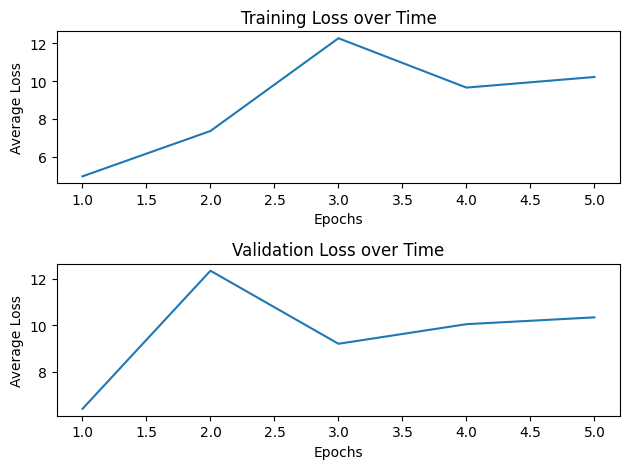

[6.402662172191085, 12.350769352354114, 9.204389286916687, 10.048788711996398, 10.341874482433658]


In [36]:
mymodel.plot_model()